In [1]:
from collections import deque

import numpy as np
import progressbar as pb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

from environments import *

from stable_baselines3.common.cmd_util import make_vec_env

c:\Users\ssuro\anaconda3\envs\torch\lib\site-packages\torch\utils\tensorboard\__init__.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion
c:\Users\ssuro\anaconda3\envs\torch\lib\site-packages\stable_baselines3\common\cmd_util.py:5: FutureWarning: Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.
  warnings.warn(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
NUM_AGENTS = 16

In [4]:
env = make_vec_env("Reacher-v4", n_envs=NUM_AGENTS)

c:\Users\ssuro\anaconda3\envs\torch\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\ssuro\anaconda3\envs\torch\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
# reset the environment
env_info = env.reset()

# size of each action
action_size = env.action_space.shape[0]
print('Size of each action:', action_size)

state_size = env.observation_space.shape[0]
print('Observation size: {}'.format(state_size))

Size of each action: 12
Observation size: 119


In [6]:
def interact(action):
    action = action.reshape(NUM_AGENTS, action_size)
    next_state, reward, done, info = env.step(action)
    return next_state.reshape(NUM_AGENTS, -1), np.array(reward).reshape(NUM_AGENTS, -1), np.array(done).reshape(NUM_AGENTS, -1)

def reset():
    state = env.reset().reshape(NUM_AGENTS, -1)
    return state

In [7]:
NET_SIZE = [512, 512]

class Actor(nn.Module):
    
    def __init__(self, 
    state_size, 
    action_size=1, 
    net_size=NET_SIZE,
    ):
        
        super(Actor, self).__init__()

        self.stack = nn.Sequential(
            nn.BatchNorm1d(state_size)
        )

        for i, size in enumerate(net_size):
            prev_size = state_size if i == 0 else net_size[i-1]
            self.stack.add_module(f'fc{i}', nn.Linear(prev_size, size))
            self.stack.add_module(f'bn{i}', nn.BatchNorm1d(size))
            self.stack.add_module(f'elu{i}', nn.ELU())

        self.fc_mu = nn.Linear(net_size[-1], action_size)
        self.fc_std = nn.Linear(net_size[-1], action_size)

    def forward(self, state, log_std_min=-20, log_std_max=2):
        x = self.stack(state)

        mean = self.fc_mu(x)
        std = self.fc_std(x)
        std = torch.clamp(std, log_std_min, log_std_max).exp()

        return mean, std

class Critic(nn.Module):
    
    def __init__(self, state_size, action_size, net_size=NET_SIZE,):
        
        super(Critic, self).__init__()

        self.stack = nn.Sequential(
            nn.BatchNorm1d(state_size+action_size)
        )

        for i, size in enumerate(net_size):            
            prev_size = state_size+action_size if i == 0 else net_size[i-1]
            self.stack.add_module(f'fc{i}', nn.Linear(prev_size, size))
            self.stack.add_module(f'elu{i}', nn.ELU())
            
        self.stack.add_module(f'fc{i}', nn.Linear(net_size[-1], 1))
        
    def forward(self, s, a):
        x = torch.cat([s, a], 1)
        return self.stack(x)

In [8]:
from algorithms.sac import Agent

agent = Agent(
    state_size=state_size, 
    action_size=action_size,
    actor=Actor,
    critic=Critic,
    n_agents=NUM_AGENTS, 
    device=device,
)

In [9]:
# agent.policy_network.load_state_dict(torch.load("./trained_models/g1-forward-homebrew/POLICY.pth"))
# agent.value_network_local.load_state_dict(torch.load("./trained_models/g1-forward-homebrew/VALUE_TARGET.pth"))
# agent.value_network_target.load_state_dict(torch.load("./trained_models/g1-forward-homebrew/VALUE_TARGET.pth"))
# agent.q_network_1.load_state_dict(torch.load("./trained_models/g1-forward-homebrew/Q_1.pth"))
# agent.q_network_2.load_state_dict(torch.load("./trained_models/g1-forward-homebrew/Q_2.pth"))

In [10]:
def run(n_episodes, t_max, print_every):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=print_every)  # last 100 scores
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()
    
    frame_counter = 0
    
    for i_episode in range(1, n_episodes+1):
        states = reset()
        score = 0
        for t in range(t_max):
            frame_counter += 1
            actions = agent.act(states)
            next_states, rewards, dones = interact(actions)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards.mean()
            if np.any(dones):
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        agent.writer.add_scalar('score/mean', score, i_episode)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tScore Mean: {:.2f}\tScore STD: {:.2f}'.format(i_episode, np.mean(scores_window), np.std(scores_window)))
            
        timer.update(i_episode)
    return scores

In [11]:
%time scores = run(t_max=int(100), n_episodes=int(1000), print_every=100)

Episode 100	Score Mean: -3308.18	Score STD: 1402.65


Episode 200	Score Mean: -6172.94	Score STD: 1360.44


Episode 300	Score Mean: -8149.44	Score STD: 1836.27


Episode 400	Score Mean: -8375.31	Score STD: 1613.97


Episode 500	Score Mean: -8264.13	Score STD: 1378.47


Episode 600	Score Mean: -8827.71	Score STD: 1763.09


Episode 700	Score Mean: -8697.48	Score STD: 1685.38


Episode 800	Score Mean: -8658.32	Score STD: 1663.52


Episode 900	Score Mean: -8890.46	Score STD: 1964.57


Episode 1000	Score Mean: -8845.54	Score STD: 1475.00
CPU times: total: 15h 4min 58s
Wall time: 1h 55min 53s


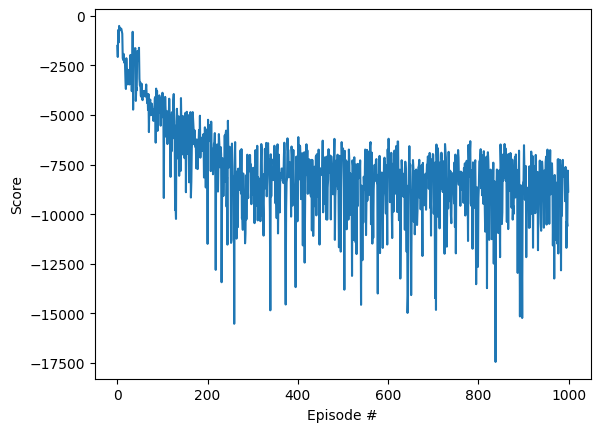

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
torch.save(agent.policy_network.state_dict(), "./trained_models/g1-forward-homebrew/POLICY.pth")
torch.save(agent.value_network_target.state_dict(), "./trained_models/g1-forward-homebrew/VALUE_TARGET.pth")
torch.save(agent.q_network_1.state_dict(), "./trained_models/g1-forward-homebrew/Q_1.pth")
torch.save(agent.q_network_2.state_dict(), "./trained_models/g1-forward-homebrew/Q_2.pth")

AttributeError: 'Agent' object has no attribute 'policy_network'

In [ ]:
env.close()

In [ ]:
from gym.wrappers import RecordVideo

env = RecordVideo(gym.make('G1Dist-v0'), './video')
state = env.reset()
done = False
while not done:

    state = torch.from_numpy(state.reshape(NUM_AGENTS, -1)).float().to(device)

    agent.policy_network.eval()
    action, _ = agent.sample_action(state)
    state, reward, done, info = env.step(action.detach().cpu().numpy())
    
env.close()